In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import thinkplot
import thinkstats2
import copy


from scipy import stats
import statsmodels.formula.api as smf
from sklearn import decomposition
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import sklearn.pipeline as skpl
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.svm import SVR

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
%matplotlib inline
sns.set()

## Data preprocessing and intro

In [2]:

df_train_y = pd.read_csv('dataset/Train/y_train.txt', header=None)
df_train_id = pd.read_csv('dataset/Train/subject_id_train.txt', header=None)
df_train_cleaned = pd.read_csv('dataset/Train/cleaned.csv')
df_train_data = pd.read_csv('dataset/Train/X_train.txt', sep=" ", header=None)

df_test_data = pd.read_csv('dataset/Test/X_test.txt', sep=" ", header=None)
df_test_y = pd.read_csv('dataset/Test/y_test.txt', header=None)
df_test_id = pd.read_csv('dataset/Test/subject_id_test.txt', header=None)
df_test_cleaned = pd.read_csv('dataset/Test/test_cleaned.csv')

df_features = pd.read_csv('dataset/features.txt', header=None, sep="\n")

all_cols = list(df_features[0])
for i,col in enumerate(all_cols):
    all_cols[i] = str(col).strip()


df_train_data.columns = all_cols
df_test_data.columns = all_cols


# df_train_id = df_train_id.rename(columns=lambda x: str(x).strip())

df_test_y.columns = ['y']
df_train_y.columns = ['y']


### DATA DESCRIPTION

### Total missing data

In [3]:
print("Total missing data from training: ", sum(df_train_data.isnull().sum(axis=1)))

Total missing data from training:  0


In [4]:
print("Total missing data from testset: ", sum(df_test_data.isnull().sum(axis=1)))

Total missing data from testset:  0


In [5]:
mean_columns = []
for c in all_cols:
    if "Mean-1" in c:
        mean_columns.append(c)

## EXPLORATORY ANALYSIS

###  Variable relationships to class

In [6]:
sample_scatter = thinkstats2.SampleRows(df_train_data, 5000) 
rel_data = df_train_data[mean_columns]

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


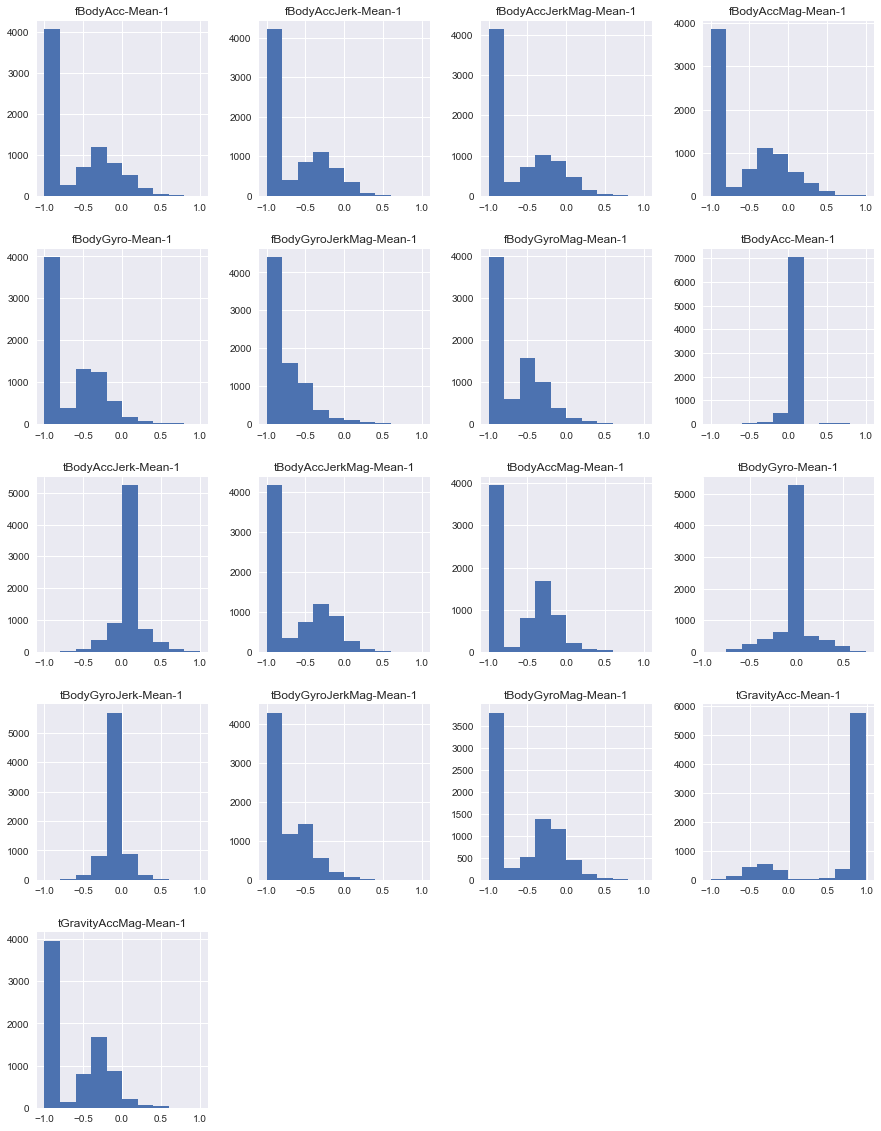

In [7]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()

rel_data.hist(ax = ax)
plt.show()

After visualizing the data, it seems like the tBodyGyroJerk, tBodyGyro has a gaussian distribution. I will say the rest of the features i selected have distributions that look gaussian although alot of their values can be found at the beginning rather than the middle which is similar to an exponential distribution

The tBodyGyroJerk mean values however do look to have an exponential distribution

### Density Plot

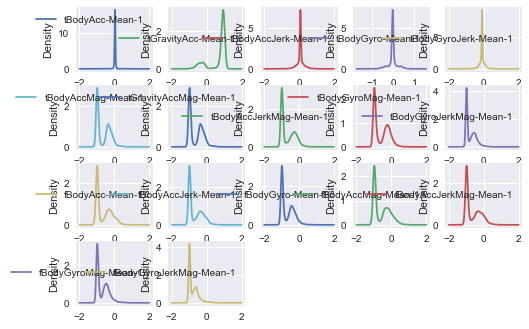

In [8]:
plt.figure(figsize=(15,8))


rel_data.plot(kind='density', subplots=True, layout=(4,5), sharex=False)

plt.show()

# FEATURE SELECTION

## MEAN FEATURES

In [9]:
mean_columns

['tBodyAcc-Mean-1',
 'tGravityAcc-Mean-1',
 'tBodyAccJerk-Mean-1',
 'tBodyGyro-Mean-1',
 'tBodyGyroJerk-Mean-1',
 'tBodyAccMag-Mean-1',
 'tGravityAccMag-Mean-1',
 'tBodyAccJerkMag-Mean-1',
 'tBodyGyroMag-Mean-1',
 'tBodyGyroJerkMag-Mean-1',
 'fBodyAcc-Mean-1',
 'fBodyAccJerk-Mean-1',
 'fBodyGyro-Mean-1',
 'fBodyAccMag-Mean-1',
 'fBodyAccJerkMag-Mean-1',
 'fBodyGyroMag-Mean-1',
 'fBodyGyroJerkMag-Mean-1']

In [10]:
X_MEAN_train = df_train_data[mean_columns]
X_MEAN_test = df_test_data[mean_columns]

### PCA

In [11]:
pcac = decomposition.PCA(.95)
pcac.fit(df_train_data)
X_pca = pcac.transform(df_train_data)
X_test_pca = pcac.transform(df_test_data)

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    if out:
        print("Importance of components:")
        #display(summary)
    return summary


def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.figure(figsize=(16,8))

    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()
    


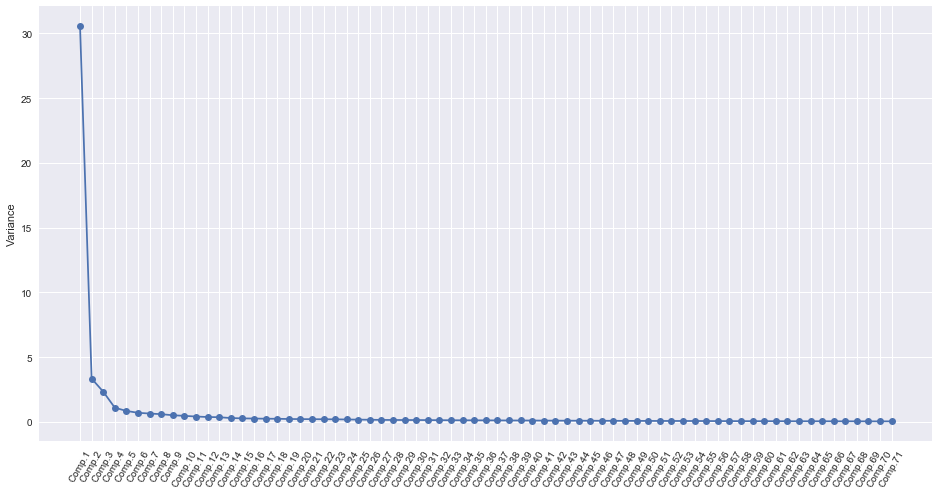

In [12]:
screeplot(pcac, df_train_data)

PCA Variance for the features that represent 95% of the dataset

### RFE

In [13]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(df_train_data, df_train_y.values.ravel())
model = SelectFromModel(lsvc,prefit=True)
X_rfe = model.transform(df_train_data)
X_rfe_test = model.transform(df_test_data)


In [14]:
X_rfe.shape

(7767, 137)

The RFE algorith has reduced the features from 561 to 134

# CLASSIFICTION

## NAIVE BAYES

In [15]:
def gaussianNaiveBayes(train_X, train_Y, test_X, fs_type):
    tr_X = copy.deepcopy(train_X)
    tr_Y = copy.deepcopy(train_Y)
    te_X = copy.deepcopy(test_X)
    
    gNB = GaussianNB()

    gNBFit = gNB.fit(tr_X, tr_Y.values.ravel())
    gNBPredict = gNB.predict(te_X)
    
    return (gNBPredict, fs_type)

    

### Naive Bayes Classification Output using PCA data

In [16]:
outa = gaussianNaiveBayes(X_pca, df_train_y, X_test_pca, "PCA")
print(classification_report(df_test_y, outa[0]))

             precision    recall  f1-score   support

          1       0.87      0.91      0.89       496
          2       0.86      0.91      0.88       471
          3       0.84      0.74      0.79       420
          4       0.93      0.76      0.84       508
          5       0.83      0.93      0.87       556
          6       1.00      0.99      0.99       545
          7       0.58      0.83      0.68        23
          8       1.00      1.00      1.00        10
          9       0.49      0.78      0.60        32
         10       0.77      0.68      0.72        25
         11       0.53      0.47      0.50        49
         12       0.67      0.74      0.70        27

avg / total       0.87      0.87      0.87      3162



### Naive Bayes Classification Output using RFE data

In [17]:
outb = gaussianNaiveBayes(X_rfe, df_train_y, X_rfe_test, "RFE")
print(classification_report(df_test_y, outb[0]))

             precision    recall  f1-score   support

          1       0.89      0.94      0.92       496
          2       0.88      0.95      0.92       471
          3       0.93      0.79      0.85       420
          4       0.91      0.65      0.75       508
          5       0.76      0.90      0.82       556
          6       1.00      0.97      0.99       545
          7       0.47      0.78      0.59        23
          8       0.60      0.90      0.72        10
          9       0.47      0.84      0.61        32
         10       0.53      0.72      0.61        25
         11       0.61      0.55      0.58        49
         12       0.41      0.41      0.41        27

avg / total       0.87      0.86      0.86      3162



### Naive Bayes Classification Output using Original data

In [18]:
outc = gaussianNaiveBayes(df_train_data, df_train_y, df_test_data, "None")
print(classification_report(df_test_y, outc[0]))

             precision    recall  f1-score   support

          1       0.83      0.84      0.83       496
          2       0.78      0.94      0.85       471
          3       0.83      0.61      0.70       420
          4       0.55      0.90      0.68       508
          5       0.86      0.40      0.54       556
          6       1.00      0.86      0.92       545
          7       0.27      0.65      0.38        23
          8       0.53      0.90      0.67        10
          9       0.52      0.75      0.62        32
         10       0.41      0.84      0.55        25
         11       0.63      0.55      0.59        49
         12       0.53      0.30      0.38        27

avg / total       0.79      0.75      0.74      3162



### Naive Bayes Classification Output using Mean data

In [128]:
outputt = gaussianNaiveBayes(X_MEAN_train, df_train_y, X_MEAN_test, "Mean")
print(classification_report(df_test_y, outputt[0]))

             precision    recall  f1-score   support

          1       0.77      0.84      0.80       496
          2       0.77      0.78      0.78       471
          3       0.74      0.59      0.66       420
          4       0.70      0.54      0.61       508
          5       0.66      0.74      0.70       556
          6       0.99      0.97      0.98       545
          7       0.12      0.52      0.20        23
          8       0.45      0.90      0.60        10
          9       0.54      0.78      0.64        32
         10       0.43      0.72      0.54        25
         11       0.66      0.47      0.55        49
         12       0.45      0.33      0.38        27

avg / total       0.76      0.74      0.75      3162



## NAIVE BAYES WITH RANDOM PRIORS

In [32]:
def gaussianNaiveBayesPriors(train_X, train_Y, test_X, fs_type, prior_size=12):
    tr_X = copy.deepcopy(train_X)
    tr_Y = copy.deepcopy(train_Y)
    te_X = copy.deepcopy(test_X)
    
    priors =np.random.dirichlet(np.ones(prior_size),size=1)[0]

    gNB = GaussianNB(priors=priors)

    gNBFit = gNB.fit(tr_X, tr_Y.values.ravel())
    gNBPredict = gNB.predict(te_X)
    return (gNBPredict, fs_type)
    

### Naive Bayes Classification Output using RFE data and random priors

In [33]:
output = gaussianNaiveBayesPriors(X_rfe, df_train_y, X_rfe_test, "rfe")
print(classification_report(df_test_y, output[0]))

             precision    recall  f1-score   support

          1       0.90      0.94      0.92       496
          2       0.89      0.95      0.92       471
          3       0.92      0.81      0.86       420
          4       0.91      0.62      0.74       508
          5       0.75      0.91      0.82       556
          6       1.00      0.97      0.99       545
          7       0.45      0.78      0.57        23
          8       0.53      0.90      0.67        10
          9       0.52      0.81      0.63        32
         10       0.52      0.68      0.59        25
         11       0.62      0.63      0.63        49
         12       0.39      0.41      0.40        27

avg / total       0.87      0.86      0.86      3162



### Naive Bayes Classification Output using PCA data and random priors


In [34]:
outputb = gaussianNaiveBayesPriors(X_pca, df_train_y, X_test_pca, "pca")
print(classification_report(df_test_y, outputb[0]))

             precision    recall  f1-score   support

          1       0.81      0.94      0.87       496
          2       0.84      0.93      0.88       471
          3       0.88      0.64      0.74       420
          4       0.97      0.66      0.79       508
          5       0.77      0.95      0.85       556
          6       1.00      0.98      0.99       545
          7       0.45      0.83      0.58        23
          8       1.00      1.00      1.00        10
          9       0.48      0.78      0.60        32
         10       0.77      0.68      0.72        25
         11       0.53      0.43      0.47        49
         12       0.61      0.74      0.67        27

avg / total       0.86      0.85      0.85      3162



### Naive Bayes Classification Output using original data and random priors


In [35]:
outputb = gaussianNaiveBayesPriors(df_train_data, df_train_y, df_test_data, "none")
print(classification_report(df_test_y, outputb[0]))

             precision    recall  f1-score   support

          1       0.82      0.85      0.83       496
          2       0.79      0.93      0.85       471
          3       0.82      0.61      0.70       420
          4       0.55      0.90      0.68       508
          5       0.86      0.39      0.53       556
          6       1.00      0.86      0.92       545
          7       0.28      0.70      0.40        23
          8       0.53      0.90      0.67        10
          9       0.52      0.75      0.62        32
         10       0.41      0.84      0.55        25
         11       0.63      0.55      0.59        49
         12       0.53      0.30      0.38        27

avg / total       0.79      0.75      0.74      3162



### Naive Bayes Classification Output using mean features data and random priors


In [36]:
outputM = gaussianNaiveBayesPriors(X_MEAN_train, df_train_y, X_MEAN_test, "Mean", 12)
print(classification_report(df_test_y, outputM[0]))

             precision    recall  f1-score   support

          1       0.57      0.86      0.68       496
          2       0.88      0.42      0.57       471
          3       0.74      0.60      0.66       420
          4       0.85      0.30      0.44       508
          5       0.60      0.90      0.72       556
          6       0.99      0.97      0.98       545
          7       0.09      0.43      0.14        23
          8       0.36      0.90      0.51        10
          9       0.56      0.75      0.64        32
         10       0.41      0.80      0.54        25
         11       0.62      0.63      0.63        49
         12       0.38      0.19      0.25        27

avg / total       0.76      0.68      0.67      3162



# SVM

In [130]:
def printHighestAndLowestValues(feat,dataframe):
    print("Feature selection Method: ", feat)
    for i,v in dataframe.groupby("kernel"):
        print("Best for Kernel: ", i)
        max_pos = v["Accuracy"].idxmax()
        print(dataframe.iloc[max_pos])
        print()

        print("Worst for Kernel: ", i)
        min_pos = v["Accuracy"].idxmin()
        print(dataframe.iloc[min_pos])
        print()
        print()
        print("=======================")
        
    print()
    print()
    print("Best overall for ", feat)
    print(dataframe.iloc[dataframe["Accuracy"].idxmax()])
    print()

    print("Worst overall for: ", feat)
    print(dataframe.iloc[dataframe["Accuracy"].idxmin()])
    print()
    print()
    print("=======================")

        

In [122]:
def plotSVMByKernel(dataframe):
    average_data = []
    for i,v in dataframe.groupby('kernel'):
        average_data.append([i, v['Accuracy'].mean()])
        print('Kernel Type:', i, 'Average Accuracy:', v['Accuracy'].mean(), '%')
    average_store_sizes_df = pd.DataFrame(average_data)
    average_store_sizes_df.columns = ['Kernel Type', 'Average Accuracy']
    print(average_store_sizes_df.dtypes)
    average_store_sizes_df.plot(kind="bar")
    plt.xlabel('Kernel Types')
    plt.ylabel('Accuracy')
    plt.title('Average accuracy by kernel type')
    plt.show()

In [37]:
def svmModel(X, y, X_test, fs_type):
    out = []
    C = [1, 10, 100, 1000]
    iters =[10, 50, 100, 150]
    kernel = ['rbf', 'poly', 'linear', 'sigmoid']
    
    outlist = []
    
    for k in kernel:
        for c in C:
            for it in iters:
                
                clf = SVC(C=c, max_iter=it, kernel=k)
                svmFit = clf.fit(X, y)
                svmPred = clf.predict(X_test)
                accuracy = accuracy_score(df_test_y, svmPred)
                outlist.append([k,c, it,accuracy])
    return(outlist, fs_type)

In [38]:
aa = svmModel(df_train_data, df_train_y, df_test_data, "nons")


/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

In [66]:
output_svm_all_feats = pd.DataFrame(aa[0], columns=["kernel", "C", "Iterations", "Accuracy"])

#### ORIGINAL DATASET SVM KERNEL 

In [131]:
printHighestAndLowestValues("Original", output_svm_all_feats)

Feature selection Method:  Original
Best for Kernel:  linear
kernel          linear
C                   10
Iterations         150
Accuracy      0.913662
Name: 39, dtype: object

Worst for Kernel:  linear
kernel          linear
C                    1
Iterations          10
Accuracy      0.810879
Name: 32, dtype: object


Best for Kernel:  poly
kernel            poly
C                  100
Iterations         150
Accuracy      0.914611
Name: 27, dtype: object

Worst for Kernel:  poly
kernel            poly
C                    1
Iterations         100
Accuracy      0.736243
Name: 18, dtype: object


Best for Kernel:  rbf
kernel            rbf
C                 100
Iterations        150
Accuracy      0.93074
Name: 11, dtype: object

Worst for Kernel:  rbf
kernel             rbf
C                   10
Iterations          10
Accuracy      0.716635
Name: 4, dtype: object


Best for Kernel:  sigmoid
kernel         sigmoid
C                 1000
Iterations         100
Accuracy      0.920936
Nam

Kernel Type: linear Average Accuracy: 0.8831040480708411 %
Kernel Type: poly Average Accuracy: 0.8204459203036053 %
Kernel Type: rbf Average Accuracy: 0.8471102150537634 %
Kernel Type: sigmoid Average Accuracy: 0.8235294117647061 %
Kernel Type          object
Average Accuracy    float64
dtype: object


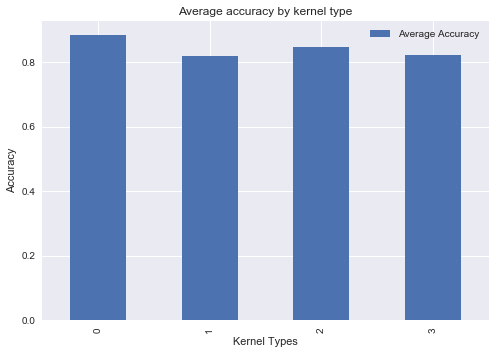

In [132]:
plotSVMByKernel(output_svm_all_feats)

In [40]:
aab = svmModel(X_pca, df_train_y, X_test_pca, "pca")
output_svm_pca = pd.DataFrame(aab[0], columns=["kernel", "C", "Iterations", "Accuracy"])

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

#### PCA DATASET SVM KERNEL 

In [133]:
printHighestAndLowestValues("PCA", output_svm_pca)

Feature selection Method:  PCA
Best for Kernel:  linear
kernel          linear
C                   10
Iterations         100
Accuracy      0.865591
Name: 38, dtype: object

Worst for Kernel:  linear
kernel         linear
C                   1
Iterations         10
Accuracy      0.75933
Name: 32, dtype: object


Best for Kernel:  poly
kernel            poly
C                 1000
Iterations         150
Accuracy      0.917141
Name: 31, dtype: object

Worst for Kernel:  poly
kernel            poly
C                   10
Iterations          10
Accuracy      0.582226
Name: 20, dtype: object


Best for Kernel:  rbf
kernel            rbf
C                  10
Iterations        150
Accuracy      0.91303
Name: 7, dtype: object

Worst for Kernel:  rbf
kernel             rbf
C                    1
Iterations          10
Accuracy      0.758065
Name: 0, dtype: object


Best for Kernel:  sigmoid
kernel         sigmoid
C                 1000
Iterations         150
Accuracy      0.748261
Name: 63, dty

Kernel Type: linear Average Accuracy: 0.8277197975964578 %
Kernel Type: poly Average Accuracy: 0.7761503795066413 %
Kernel Type: rbf Average Accuracy: 0.8407060404807083 %
Kernel Type: sigmoid Average Accuracy: 0.6666666666666666 %
Kernel Type          object
Average Accuracy    float64
dtype: object


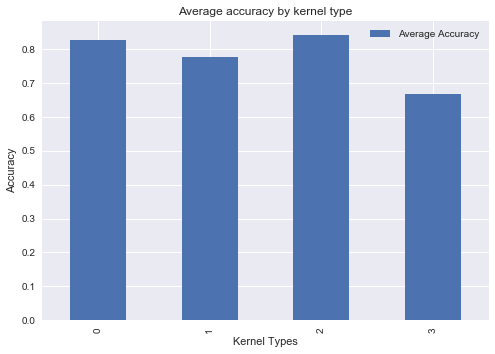

In [124]:
plotSVMByKernel(output_svm_pca)

In [44]:
aac = svmModel(X_rfe, df_train_y, X_rfe_test, "rfe")
output_svm_rfe = pd.DataFrame(aac[0], columns=["kernel", "C", "Iterations", "Accuracy"])

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

#### RFE DATASET SVM KERNEL 

In [134]:
printHighestAndLowestValues("RFE", output_svm_rfe)

Feature selection Method:  RFE
Best for Kernel:  linear
kernel          linear
C                   10
Iterations         100
Accuracy      0.901328
Name: 38, dtype: object

Worst for Kernel:  linear
kernel          linear
C                   10
Iterations         150
Accuracy      0.837761
Name: 39, dtype: object


Best for Kernel:  poly
kernel            poly
C                  100
Iterations         150
Accuracy      0.938014
Name: 27, dtype: object

Worst for Kernel:  poly
kernel            poly
C                    1
Iterations         100
Accuracy      0.791588
Name: 18, dtype: object


Best for Kernel:  rbf
kernel             rbf
C                 1000
Iterations         150
Accuracy      0.904491
Name: 15, dtype: object

Worst for Kernel:  rbf
kernel             rbf
C                   10
Iterations          10
Accuracy      0.795066
Name: 4, dtype: object


Best for Kernel:  sigmoid
kernel         sigmoid
C                  100
Iterations         150
Accuracy      0.924099
Name

Kernel Type: linear Average Accuracy: 0.8699399114484504 %
Kernel Type: poly Average Accuracy: 0.8735768500948766 %
Kernel Type: rbf Average Accuracy: 0.8633578431372549 %
Kernel Type: sigmoid Average Accuracy: 0.8421884882985453 %
Kernel Type          object
Average Accuracy    float64
dtype: object


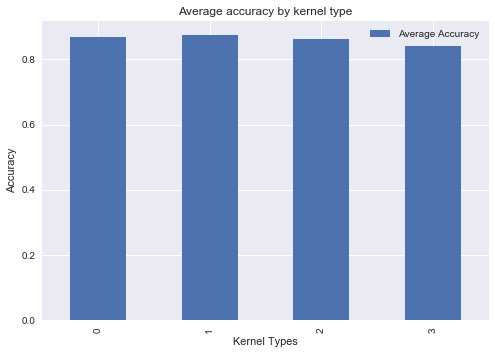

In [135]:
plotSVMByKernel(output_svm_rfe)

In [136]:
aad = svmModel(X_MEAN_train, df_train_y, X_MEAN_test, "mean")
output_svm_mean = pd.DataFrame(aad[0], columns=["kernel", "C", "Iterations", "Accuracy"])

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

#### MEANS DATASET SVM KERNEL 

In [138]:
printHighestAndLowestValues("MEAN VALUES",output_svm_mean)

Feature selection Method:  MEAN VALUES
Best for Kernel:  linear
kernel          linear
C                   10
Iterations         150
Accuracy      0.747628
Name: 39, dtype: object

Worst for Kernel:  linear
kernel          linear
C                  100
Iterations          10
Accuracy      0.547438
Name: 40, dtype: object


Best for Kernel:  poly
kernel           poly
C                 100
Iterations        100
Accuracy      0.67141
Name: 26, dtype: object

Worst for Kernel:  poly
kernel            poly
C                 1000
Iterations          10
Accuracy      0.582226
Name: 28, dtype: object


Best for Kernel:  rbf
kernel             rbf
C                  100
Iterations         150
Accuracy      0.767552
Name: 11, dtype: object

Worst for Kernel:  rbf
kernel             rbf
C                   10
Iterations          50
Accuracy      0.522454
Name: 5, dtype: object


Best for Kernel:  sigmoid
kernel         sigmoid
C                  100
Iterations         150
Accuracy      0.739089


Kernel Type: linear Average Accuracy: 0.6509922517394056 %
Kernel Type: poly Average Accuracy: 0.6353178368121443 %
Kernel Type: rbf Average Accuracy: 0.638974541429475 %
Kernel Type: sigmoid Average Accuracy: 0.6899114484503479 %
Kernel Type          object
Average Accuracy    float64
dtype: object


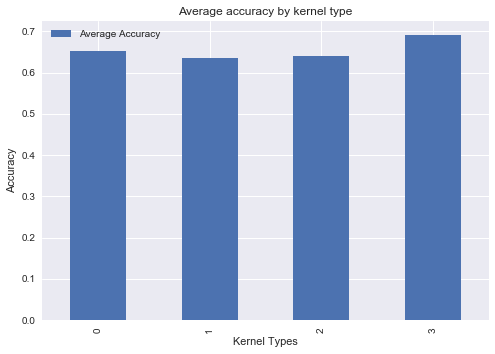

In [127]:
plotSVMByKernel(output_svm_mean)